In [2]:
import numpy as np
import tifffile
import glob
import pandas
import os
from tqdm.notebook import tqdm
import griottes
from saucisson import image_preparation

# Notebook for generating file with all data
- Put threshold on average intensity for nuclear signals
- Aggregate with files coming from NN classification for membrane signals
- Saving datafile

### Load segmented image

In [2]:
IMAGE_PATH = r'Example_image'
img_name = '221212_6_labeled.tif'
img_seg = tifffile.imread(os.path.join(IMAGE_PATH, img_name))

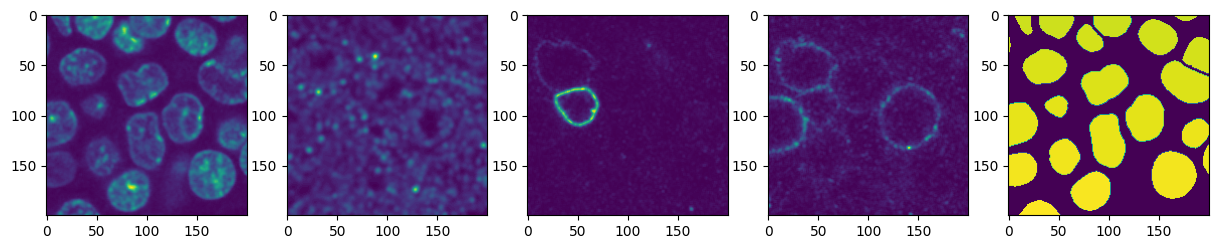

In [3]:
nx,ny,nc = img_seg.shape

fig, ax = plt.subplots(1,nc, figsize = (15,5))

for i in range(nc):
    ax[i].imshow(img_seg[5000:5200,5000:5200,i])

### Classify cells based on nuclear signal (if necessary)
Put threshold on intensity in the nucleus of the cells to classify positive and negative cells

In [5]:
# Load cell properties (with average intensity signal in nucleus for each channel + cell positions)
prop = pandas.read_csv(os.path.join(IMAGE_PATH, '221212_6_labeled.csv'))

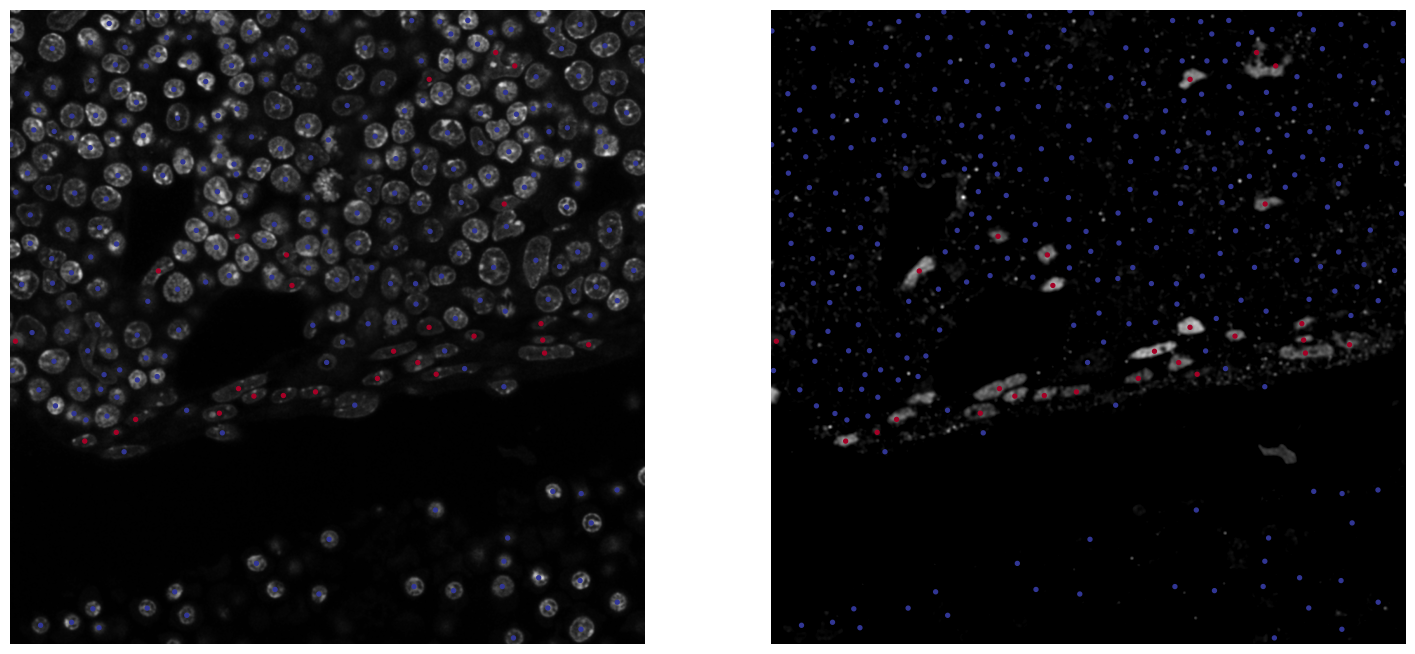

In [5]:
nuc_channel = 4 # Channel with nuclei masks
channel = 1 # Channel with nuclear fluorescence signal of interest

thresh = 2.7 # Threshold to adjust

# Choose a small window on the image to adjust the threshold
minx = 6000
maxx = 7000
miny = 6000
maxy = 7000

# Select cells in this window
label_list = np.unique(img_seg[minx:maxx, miny:maxy,nuc_channel])[1:]

sample_plot = pandas.DataFrame()
for label in label_list:
    sample_plot = pandas.concat([sample_plot, prop[(prop.label == label) & (prop.x > minx) & (prop.x < maxx) & (prop.y > miny) & (prop.y < maxy)]])
sample_plot.x -= minx
sample_plot.y -= miny

# Plot Image overlayed with Classification based on nlucear signal (thresholding)
image_preparation.test_color_threshold(
    img_seg[minx:maxx, miny:maxy],
    channel,
    0,
    sample_plot,
    'log_mean_intensity_' + str(channel),
    thresh,
    vmin = 10,
    vmax = 70,
    s = 8)

### Concatenate classification from neural network and thresholding in a common file

In [16]:
# Load cell properties (with average intensity signal in nucleus for each channel + cell positions)
prop = pandas.read_csv(os.path.join(IMAGE_PATH, '221212_6_labeled.csv'))

# Read data from Neural Network classification
Kit_pos_cells = pandas.read_csv(os.path.join(IMAGE_PATH, 'Kit_NN_classification.csv'))
CD45_pos_cells = pandas.read_csv(os.path.join(IMAGE_PATH, 'CD45_NN_classification.csv'))

# Combine these data
prop.index = prop.label
Kit_pos_cells.index = Kit_pos_cells.label
Kit_pos_cells = Kit_pos_cells[['label', 'Kit_NN_prediction_value']]
CD45_pos_cells.index = CD45_pos_cells.label
CD45_pos_cells = CD45_pos_cells[['label', 'CD45_NN_prediction_value']]
prop = pandas.concat([prop, Kit_pos_cells, CD45_pos_cells], axis=1)
prop = prop.dropna(subset=['Kit_NN_prediction_value'])
prop.index = np.arange(len(prop))
prop['Kit_NN_prediction_value'] = prop['Kit_NN_prediction_value'].astype(int)
prop['CD45_NN_prediction_value'] = prop['CD45_NN_prediction_value'].astype(int)

# Add previously adjusted threshold on the corresponding channel
prop['Lhx2_thresh_prediction_value'] = (prop['log_mean_intensity_1'] > thresh).astype(int)

# Create a column with cell properties for each channel
prop['cell_properties'] = ''
marker_list = ['CD45', 'Kit', 'Lhx2']
category_channels = ['CD45_NN_prediction_value','Kit_NN_prediction_value', 'Lhx2_thresh_prediction_value']
pm_list = ['-','+']
prop = image_preparation.cell_type_maker(prop, category_channels, marker_list, pm_list)

# Add a number for each cell different phenotypes
i = 0
for cell_type in np.unique(prop.cell_properties.values):
    print(cell_type)
    prop.loc[prop.cell_properties == cell_type, 'cell_type'] = i
    i += 1
prop.index = np.arange(len(prop))
prop['cell_type'] = prop.cell_type.values.astype(int)

# Create a column called legend
prop['legend'] = prop['cell_properties']

# Eliminate any potential duplicated columns
prop = prop.loc[:,~prop.columns.duplicated()]

CD45+, Kit+, Lhx2+
CD45+, Kit+, Lhx2-
CD45+, Kit-, Lhx2+
CD45+, Kit-, Lhx2-
CD45-, Kit+, Lhx2+
CD45-, Kit+, Lhx2-
CD45-, Kit-, Lhx2+
CD45-, Kit-, Lhx2-


### Eliminate possible incompatible cell types
Sometimes a few cells can be not correctly classified by neural network
In case of incompatible cell type attribution, we give priority of the cell type given by thresholding (which is in general more clear)

In [18]:
# Specify forbidden cell types
forbidden_cell_prop_list = ['CD45+, Kit+, Lhx2+',
                            'CD45+, Kit-, Lhx2+',
                            'CD45-, Kit+, Lhx2+']

# Give priority to nuclear signal
for cell_prop in forbidden_cell_prop_list:
    prop.loc[prop.cell_properties == cell_prop, 'Kit_NN_prediction_value'] = 0
    prop.loc[prop.cell_properties == cell_prop, 'CD45_NN_prediction_value'] = 0

# Reattribute cell types
prop['cell_properties'] = ''
marker_list = ['CD45', 'Kit', 'Lhx2']
category_channels = ['CD45_NN_prediction_value','Kit_NN_prediction_value', 'Lhx2_thresh_prediction_value']
pm_list = ['-','+']
prop = image_preparation.cell_type_maker(prop, category_channels, marker_list, pm_list)

# Add a number for each cell different phenotypes
i = 0
for cell_type in np.unique(prop.cell_properties.values):
    print(cell_type)
    prop.loc[prop.cell_properties == cell_type, 'cell_type'] = i
    i += 1
prop.index = np.arange(len(prop))
prop['cell_type'] = prop.cell_type.values.astype(int)

# Create a column called legend
prop['legend'] = prop['cell_properties']

# Eliminate any potential duplicated columns
prop = prop.loc[:,~prop.columns.duplicated()]

CD45+, Kit+, Lhx2-
CD45+, Kit-, Lhx2-
CD45-, Kit+, Lhx2-
CD45-, Kit-, Lhx2+
CD45-, Kit-, Lhx2-


### Save table

In [20]:
prop.to_csv(os.path.join(IMAGE_PATH, '221212_6_classified.csv'))